In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# excluded_stations = ['GT0351005', 'GT0918001', 'GT0925002', 'GT1067015', 'GT1213007',
#        'GT1519900', 'GT1541007', 'GT1578027', 'GT1586034', 'GT1931012',
#        'GT2216002', 'GT2224006', 'GT2290014', 'GT2626900', 'GT2642900',
#        'GT2747021', 'GT2764030', 'GT3029004', 'GT3551010', 'GT3813009',
#        'GT4712001', 'GT4764007', 'GT4802002', 'GT4977004', 'GT5883030',
#        'GT6123019', 'GT6459900', 'GT6852001', 'GT7536006', 'GT7587900',
#        'GT7857001', 'GT8549900', 'GT8889023', 'GT9141014', 'GT9162023',
#        'GT9451004', 'GT811012B', 'GT8407001']

In [3]:
def load_station_data(path):
    """
    Load all CSV files from a directory, exclude specified unusable station IDs, 
    and return a list of pandas DataFrames.
    
    Parameters:
        path (str): Path to the folder containing station CSV files.
        
    Returns:
        List[pd.DataFrame]: List of filtered DataFrames for each station.
    """
    # List of unusable station IDs
    excluded_stations = {
        'GT0351005', 'GT1067015', 'GT1213007', 'GT1519900', 'GT1541007',
        'GT1586034', 'GT2290014', 'GT2626900', 'GT2642900', 'GT6123019',
        'GT2216002', 'GT3813009', 'GT9162023', 'GT5883030', 'GT1578027',
        'GT4712001', 'GT4764007', 'GT4802002', 'GT1931012', 'GT6459900',
        'GT7587900', 'GT3029004', 'GT2224006', 'GT7857001', 'GT8889023',
        'GT9141014', 'GT2764030', 'GT811012B', 'GT8407001', 'GT7536006'
    }

    # Get all CSV file paths in the directory
    station_files = [os.path.join(path, file)
                     for file in os.listdir(path) if file.endswith('.csv')]

    # Load data and exclude unwanted stations
    stations_df = []
    for file in station_files:
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        well_id = df['WELL ID'].iloc[0] if 'WELL ID' in df.columns else None
        if well_id not in excluded_stations:
            stations_df.append(df)

    return stations_df

path_inm = r"F:\Reanalysis Data\Monthly\Combined\INM CM5 0\corrected"
path_ass = r"F:\Reanalysis Data\Monthly\Combined\ASSESS ESM 15\corrected"

stations_df = load_station_data(path_inm)
stations_df_ass = load_station_data(path_ass)

In [4]:
stations_df[0].head()

,DISTRICT,LATITUDE,LONGITUDE,Test MSE (lr),Test MSE (xgb),Test R2 (lr),Test R2 (xgb),Train MSE (lr),Train MSE (xgb),Train R2 (lr),...,downscaled_ssp_245_xgb,downscaled_ssp_585_lr,downscaled_ssp_585_xgb,wtable,mbc_hist_lr,mbc_hist_xgb,mbc_ssp_245_lr,mbc_ssp_245_xgb,mbc_ssp_585_lr,mbc_ssp_585_xgb
1980-01-01,Barguna,22.32,90.3275,0.034066,0.03295,0.733681,0.742409,0.036924,0.037522,0.758719,...,NaN,NaN,NaN,2.0925,2.418340,2.099057,NaN,NaN,NaN,NaN
1980-02-01,Barguna,22.32,90.3275,0.034066,0.03295,0.733681,0.742409,0.036924,0.037522,0.758719,...,NaN,NaN,NaN,2.1550,2.026435,2.254671,NaN,NaN,NaN,NaN
1980-03-01,Barguna,22.32,90.3275,0.034066,0.03295,0.733681,0.742409,0.036924,0.037522,0.758719,...,NaN,NaN,NaN,2.0260,2.077348,2.300713,NaN,NaN,NaN,NaN
1980-04-01,Barguna,22.32,90.3275,0.034066,0.03295,0.733681,0.742409,0.036924,0.037522,0.758719,...,NaN,NaN,NaN,1.9325,2.113230,2.267457,NaN,NaN,NaN,NaN
1980-05-01,Barguna,22.32,90.3275,0.034066,0.03295,0.733681,0.742409,0.036924,0.037522,0.758719,...,NaN,NaN,NaN,1.6550,2.059079,1.797996,NaN,NaN,NaN,NaN


In [17]:
station_stats = []

try:
    for i, (df_inm, df_ass) in enumerate(zip(stations_df, stations_df_ass)):
        try:
            # Only work with numeric columns relevant to water table values
            cols_ssp245 = ['mbc_ssp_245_xgb']
            cols_ssp585 = ['mbc_ssp_585_xgb']

            # Drop NaN values for each scenario
            df_inm_ssp245 = df_inm.dropna(subset=cols_ssp245)
            df_ass_ssp245 = df_ass.dropna(subset=cols_ssp245)

            df_inm_ssp585 = df_inm.dropna(subset=cols_ssp585)
            df_ass_ssp585 = df_ass.dropna(subset=cols_ssp585)

            # Compute average for each SSP scenario
            ssp245_avg = (df_inm_ssp245[cols_ssp245].values + df_ass_ssp245[cols_ssp245].values) / 2
            ssp585_avg = (df_inm_ssp585[cols_ssp585].values + df_ass_ssp585[cols_ssp585].values) / 2

            # Get station metadata
            district_inm = df_inm['DISTRICT'].iloc[0]
            district_ass = df_ass['DISTRICT'].iloc[0]
            upazila_inm = df_inm['UPAZILA'].iloc[0]
            upazila_ass = df_ass['UPAZILA'].iloc[0]
            well_id_inm = df_inm['WELL ID'].iloc[0]
            well_id_ass = df_ass['WELL ID'].iloc[0]

            # Check for mismatches
            if district_inm != district_ass:
                print(f"⚠️  WARNING: District mismatch at station {i+1}")
                print(f"   INM: {district_inm}, ASSESS: {district_ass}")

            if upazila_inm != upazila_ass:
                print(f"⚠️  WARNING: Upazila mismatch at station {i+1}")
                print(f"   INM: {upazila_inm}, ASSESS: {upazila_ass}")

            if well_id_inm != well_id_ass:
                print(f"⚠️  WARNING: Well ID mismatch at station {i+1}")
                print(f"   INM: {well_id_inm}, ASSESS: {well_id_ass}")

            # Create separate DataFrame for this station
            station_data = pd.DataFrame({
                'ssp245': ssp245_avg.flatten(),
                'ssp585': ssp585_avg.flatten()
            })
            
            # Add original dataframe indices
            station_data.index = df_inm_ssp245.index

            # Add station metadata (repeated for all rows)
            station_data['District'] = district_inm
            station_data['Upazila'] = upazila_inm
            station_data['Well_Id'] = well_id_inm
            station_data['lat'] = df_inm['LATITUDE'].iloc[0]
            station_data['lon'] = df_inm['LONGITUDE'].iloc[0]
            

            # Append this station's DataFrame to the list
            station_stats.append(station_data)
            print(f"✅ Created DataFrame for {district_inm} - {upazila_inm} (Station {i+1})")
            print(f"   DataFrame shape: {station_data.shape}")

        except Exception as station_error:
            print(f"❌ Error processing station {i+1}: {station_error}")
            continue

except Exception as e:
    print(f"❌ Fatal error: {e}")


✅ Created DataFrame for Barguna - Bamna (Station 1)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Bhola - Bhola Sadar (Station 2)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Bhola - Char Fasson (Station 3)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Brahmanbaria - Brahamanbaria Sadar (Station 4)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Chandpur - Chandpur Sadar (Station 5)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Cumilla - Cumilla Sadar (Station 6)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Dinajpur - Hakimpur (Station 7)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Faridpur - Faridpur Sadar  (Station 8)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Faridpur - Faridpur Sadar  (Station 9)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Gaibandha - Sadullapur (Station 10)
   DataFrame shape: (1032, 7)
✅ Created DataFrame for Gopalganj - Kotali para (Station 11)
   DataFrame shape: (1032, 7)
✅ Created 

In [21]:
for df in station_stats:
    
    df.to_csv(rf"C:\Users\Acer\Desktop\Thesis\Meeting 05\Final paper\Stats\Ensemble\{df['Well_Id'].iloc[0]}.csv")

In [4]:
station_stats = []

# Function to calculate Nash-Sutcliffe Efficiency
def nash_sutcliffe_efficiency(observed, predicted):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE)
    NSE = 1 - (sum of squared residuals) / (sum of squared deviations from observed mean)
    
    Perfect model: NSE = 1
    Model as good as observed mean: NSE = 0
    Model worse than observed mean: NSE < 0
    """
    # Remove any NaN values from both arrays
    mask = ~(pd.isna(observed) | pd.isna(predicted))
    obs_clean = observed[mask]
    pred_clean = predicted[mask]
    
    if len(obs_clean) == 0:
        return np.nan
    
    # Calculate NSE
    numerator = np.sum((obs_clean - pred_clean) ** 2)
    denominator = np.sum((obs_clean - np.mean(obs_clean)) ** 2)
    
    if denominator == 0:
        return np.nan
    
    nse = 1 - (numerator / denominator)
    return nse

# Load both datasets
stations_df = load_station_data(path_inm)
stations_df_ass = load_station_data(path_ass)

try:
    for i, (df_inm, df_ass) in enumerate(zip(stations_df, stations_df_ass)):
        data = {}
        
        # Drop rows with missing wtable values for both datasets
        df_inm = df_inm.dropna(subset=['wtable'])
        df_ass = df_ass.dropna(subset=['wtable'])
        
        # Check if both datasets have matching district and upazila names
        district_inm = df_inm['DISTRICT'].iloc[0]
        district_ass = df_ass['DISTRICT'].iloc[0]
        upazila_inm = df_inm['UPAZILA'].iloc[0]
        upazila_ass = df_ass['UPAZILA'].iloc[0]
        well_id_inm = df_inm['WELL ID'].iloc[0]
        well_id_ass = df_ass['WELL ID'].iloc[0]
        
        if district_inm != district_ass:
            print(f"⚠️  WARNING: District mismatch at station {i+1}")
            print(f"   INM: {district_inm}, ASSESS: {district_ass}")
        
        if upazila_inm != upazila_ass:
            print(f"⚠️  WARNING: Upazila mismatch at station {i+1}")
            print(f"   INM: {upazila_inm}, ASSESS: {upazila_ass}")
            
        if well_id_inm != well_id_ass:
            print(f"⚠️  WARNING: Well ID mismatch at station {i+1}")
            print(f"   INM: {well_id_inm}, ASSESS: {well_id_ass}")
        
        # Basic station info (using INM dataset as primary)
        data['District'] = district_inm
        data['Upaliza'] = upazila_inm
        data['Well Id'] = well_id_inm
        data['lat'] = df_inm['LATITUDE'].iloc[0]
        data['lon'] = df_inm['LONGITUDE'].iloc[0]
        data['range'] = f"{df_inm['wtable'].dropna().index.min().year} - {df_inm['wtable'].dropna().index.max().year}"
        
        # Observed data stats (same for both since it's wtable)
        data['obs_mean'] = df_inm['wtable'].mean()
        data['obs_std'] = df_inm['wtable'].std()
        data['obs_min'] = df_inm['wtable'].min()
        data['obs_max'] = df_inm['wtable'].max()
        
        # INM dataset stats and metrics
        data['mse_inm_lr'] = mean_squared_error(df_inm['wtable'], df_inm['mbc_hist_lr'])
        data['mse_inm_xgb'] = mean_squared_error(df_inm['wtable'], df_inm['mbc_hist_xgb'])
        data['r2_inm_lr'] = r2_score(df_inm['wtable'], df_inm['mbc_hist_lr'])
        data['r2_inm_xgb'] = r2_score(df_inm['wtable'], df_inm['mbc_hist_xgb'])
        data['corr_inm_lr'] = df_inm['wtable'].corr(df_inm['mbc_hist_lr'])
        data['corr_inm_xgb'] = df_inm['wtable'].corr(df_inm['mbc_hist_xgb'])
        data['nse_inm_lr'] = nash_sutcliffe_efficiency(df_inm['wtable'], df_inm['mbc_hist_lr'])
        data['nse_inm_xgb'] = nash_sutcliffe_efficiency(df_inm['wtable'], df_inm['mbc_hist_xgb'])
        data['inm_mean_lr'] = df_inm['mbc_hist_lr'].mean()
        data['inm_std_lr'] = df_inm['mbc_hist_lr'].std()
        data['inm_mean_xgb'] = df_inm['mbc_hist_xgb'].mean()
        data['inm_std_xgb'] = df_inm['mbc_hist_xgb'].std()
        
        # ASSESS dataset stats and metrics
        data['mse_access_lr'] = mean_squared_error(df_ass['wtable'], df_ass['mbc_hist_lr'])
        data['mse_access_xgb'] = mean_squared_error(df_ass['wtable'], df_ass['mbc_hist_xgb'])
        data['r2_access_lr'] = r2_score(df_ass['wtable'], df_ass['mbc_hist_lr'])
        data['r2_access_xgb'] = r2_score(df_ass['wtable'], df_ass['mbc_hist_xgb'])
        data['corr_access_lr'] = df_ass['wtable'].corr(df_ass['mbc_hist_lr'])
        data['corr_access_xgb'] = df_ass['wtable'].corr(df_ass['mbc_hist_xgb'])
        data['nse_access_lr'] = nash_sutcliffe_efficiency(df_ass['wtable'], df_ass['mbc_hist_lr'])
        data['nse_access_xgb'] = nash_sutcliffe_efficiency(df_ass['wtable'], df_ass['mbc_hist_xgb'])
        data['access_mean_lr'] = df_ass['mbc_hist_lr'].mean()
        data['access_std_lr'] = df_ass['mbc_hist_lr'].std()
        data['access_mean_xgb'] = df_ass['mbc_hist_xgb'].mean()
        data['access_std_xgb'] = df_ass['mbc_hist_xgb'].std()
        
        station_stats.append(data)
        print(f"✅ Done processing {data['District']} - {data['Upaliza']} (Station {i+1})")
        
except Exception as e:
    print(f"Error processing station {i+1} - {data.get('District', 'Unknown')}: {e}")
    print(f"Well ID: {data.get('Well Id', 'Unknown')}")
    
# Create DataFrame with all statistics
stats = pd.DataFrame(station_stats)

✅ Done processing Barguna - Bamna (Station 1)
✅ Done processing Bhola - Bhola Sadar (Station 2)
✅ Done processing Bhola - Char Fasson (Station 3)
✅ Done processing Brahmanbaria - Brahamanbaria Sadar (Station 4)
✅ Done processing Chandpur - Chandpur Sadar (Station 5)
✅ Done processing Cumilla - Cumilla Sadar (Station 6)
✅ Done processing Dinajpur - Hakimpur (Station 7)
✅ Done processing Faridpur - Faridpur Sadar  (Station 8)
✅ Done processing Faridpur - Faridpur Sadar  (Station 9)
✅ Done processing Gaibandha - Sadullapur (Station 10)
✅ Done processing Gopalganj - Kotali para (Station 11)
✅ Done processing Jamalpur - Jamalpur Sadar (Station 12)
✅ Done processing Jessore - Jessore Sadar (Station 13)
✅ Done processing Khulna - Khulna Sadar (Station 14)
✅ Done processing Kishoreganj - Itna (Station 15)
✅ Done processing Kurigram - Rajarhat (Station 16)
✅ Done processing Kushtia - Bheramara (Station 17)
✅ Done processing Madaripur - Kalkini (Station 18)
✅ Done processing Meherpur - Meherpur 

In [110]:
stats.to_csv(r"C:\Users\Acer\Desktop\Thesis\Meeting 05\Final paper\Stats\station_stats_both_gcm.csv", index=False)

In [5]:
stats.columns

Index(['District', 'Upaliza', 'Well Id', 'lat', 'lon', 'range', 'obs_mean',
       'obs_std', 'obs_min', 'obs_max', 'mse_inm_lr', 'mse_inm_xgb',
       'r2_inm_lr', 'r2_inm_xgb', 'corr_inm_lr', 'corr_inm_xgb', 'nse_inm_lr',
       'nse_inm_xgb', 'inm_mean_lr', 'inm_std_lr', 'inm_mean_xgb',
       'inm_std_xgb', 'mse_access_lr', 'mse_access_xgb', 'r2_access_lr',
       'r2_access_xgb', 'corr_access_lr', 'corr_access_xgb', 'nse_access_lr',
       'nse_access_xgb', 'access_mean_lr', 'access_std_lr', 'access_mean_xgb',
       'access_std_xgb'],
      dtype='object')

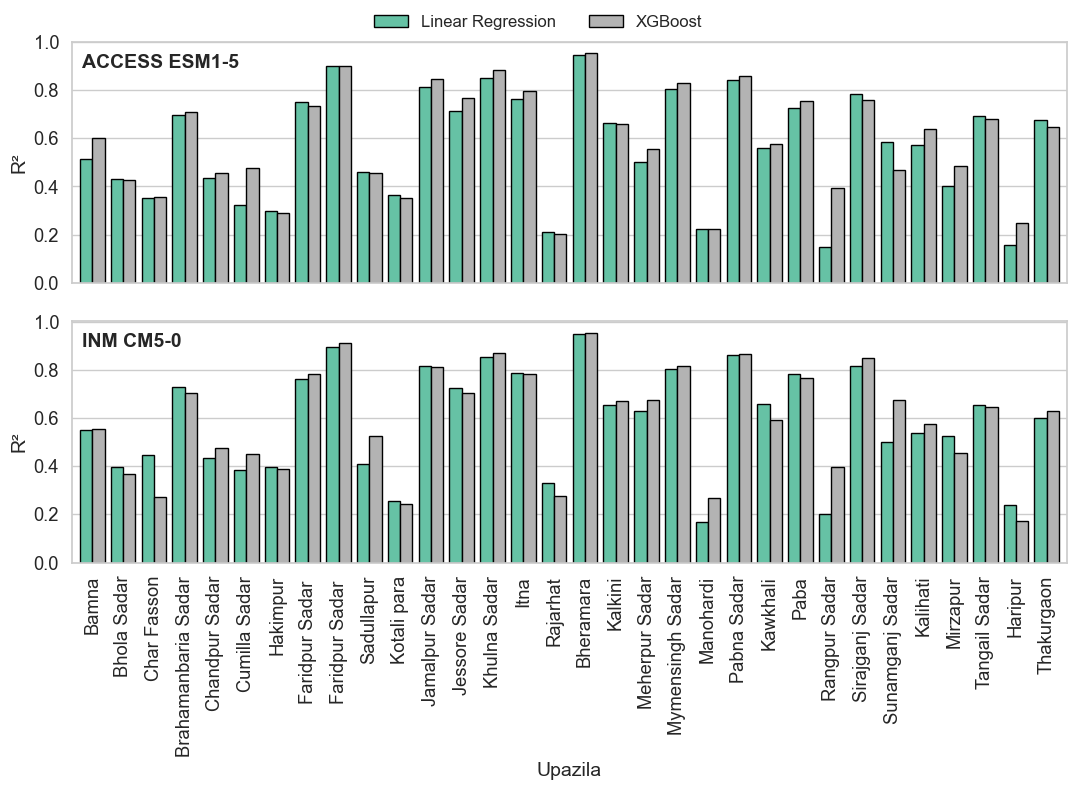

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.2)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(11, 8), sharey=True)

# First plot: ACCESS models
bars1 = stats.set_index(['Upaliza'])[['r2_access_lr', 'r2_access_xgb']].plot(
    kind='bar',
    ax=axes[0],
    width=0.8,
    colormap='Set2',
    edgecolor='black',
    legend=False
)

axes[0].set_xlabel("")
axes[0].set_ylabel("R²", fontsize=14)
axes[0].set_xticklabels([])
axes[0].yaxis.grid(True)
axes[0].xaxis.grid(False)

# Add model name
axes[0].text(0.01, 0.95, "ACCESS ESM1-5", transform=axes[0].transAxes,
             fontsize=14, fontweight='bold', verticalalignment='top')

# Second plot: INM models
bars2 = stats.set_index(['Upaliza'])[['r2_inm_lr', 'r2_inm_xgb']].plot(
    kind='bar',
    ax=axes[1],
    width=0.8,
    colormap='Set2',
    edgecolor='black',
    legend=False
)

axes[1].set_xlabel("Upazila", fontsize=14)
axes[1].set_ylabel("R²", fontsize=14)
axes[1].yaxis.grid(True)
axes[1].xaxis.grid(False)

# Add model name
axes[1].text(0.01, 0.95, "INM CM5-0", transform=axes[1].transAxes,
             fontsize=14, fontweight='bold', verticalalignment='top')

# Add shared legend between the subplots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, ["Linear Regression", "XGBoost"],
           loc='upper center',
           ncol=2, fontsize=12, frameon=False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95) 
# Show
plt.show()


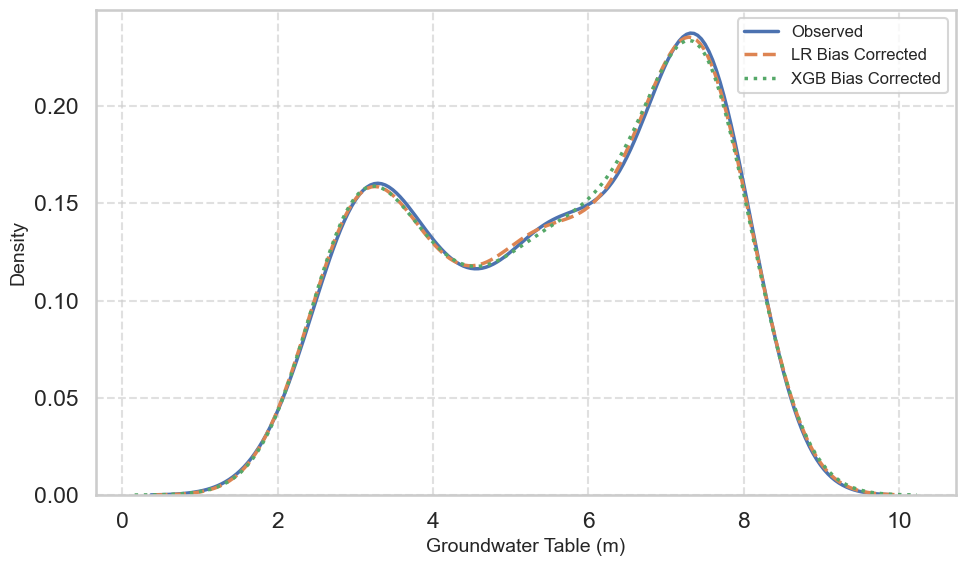

In [55]:
import seaborn as sns

# Set a modern style
sns.set(style="whitegrid", context="talk", palette="deep")

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=stations_df[16], x='wtable', label='Observed', linewidth=2.5)
sns.kdeplot(data=stations_df[16], x='mbc_hist_lr', label='LR Bias Corrected', linewidth=2.5, linestyle='--')
sns.kdeplot(data=stations_df[16], x='mbc_hist_xgb', label='XGB Bias Corrected', linewidth=2.5, linestyle=':')

# Add title and labels
plt.xlabel("Groundwater Table (m)", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Customize legend
plt.legend(fontsize=12, title_fontsize=13)

# Add grid and tight layout
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


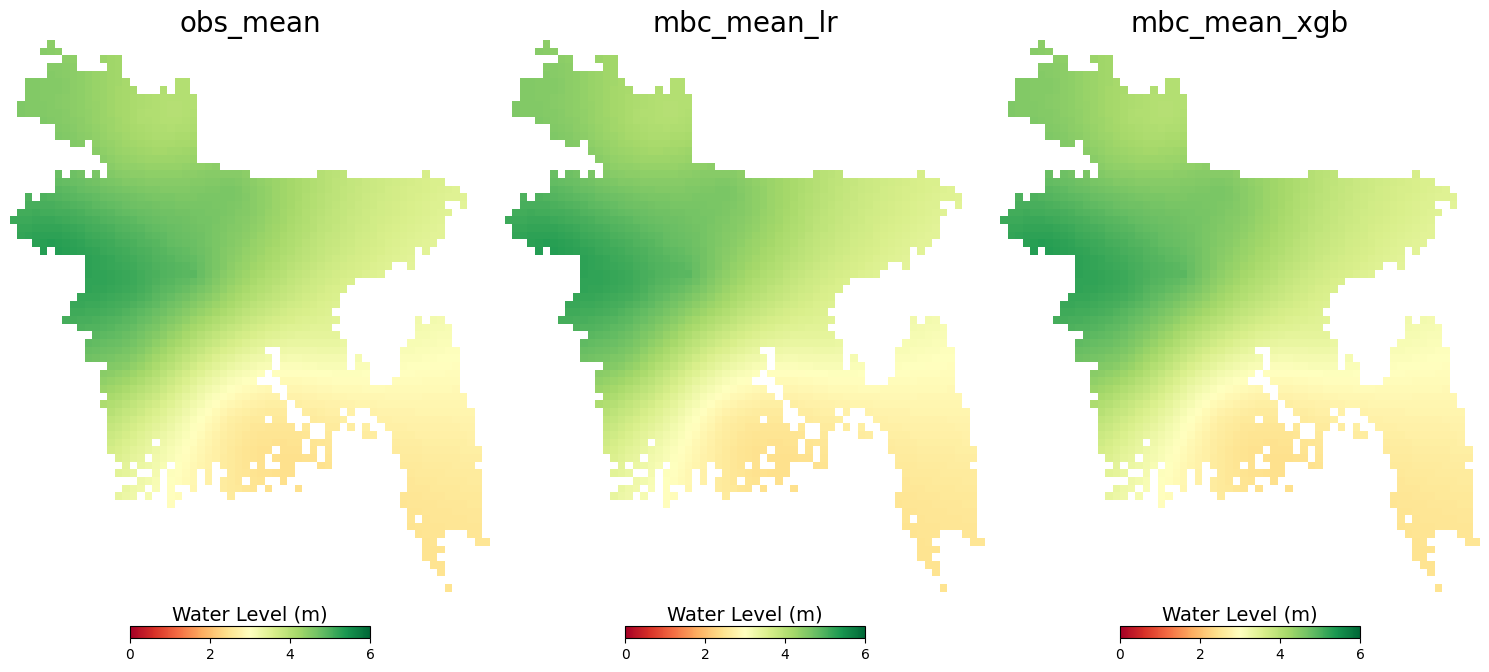

In [51]:
from Interpolate_Clip_Map import interpolated_clipped_map

shapefile_path = r"E:\Downloads\bgd_adm_bbs_20201113_shp\bgd_adm_bbs_20201113_SHP\bgd_admbnda_adm2_bbs_20201113.shp"
interpolated_clipped_map(stats, ['obs_mean', 'mbc_mean_lr', 'mbc_mean_xgb'], shapefile_path,
                         cbar_label= 'Water Level (m)',figsize=(15, 7.5), rows=1, cols=3)

In [52]:
shapefile = gpd.read_file(shapefile_path).to_crs(epsg=4326)
geometry = [Point(xy) for xy in zip(stats['lon'], stats['lat'])]
gdf = gpd.GeoDataFrame(stats, geometry=geometry, crs='EPSG:4326')

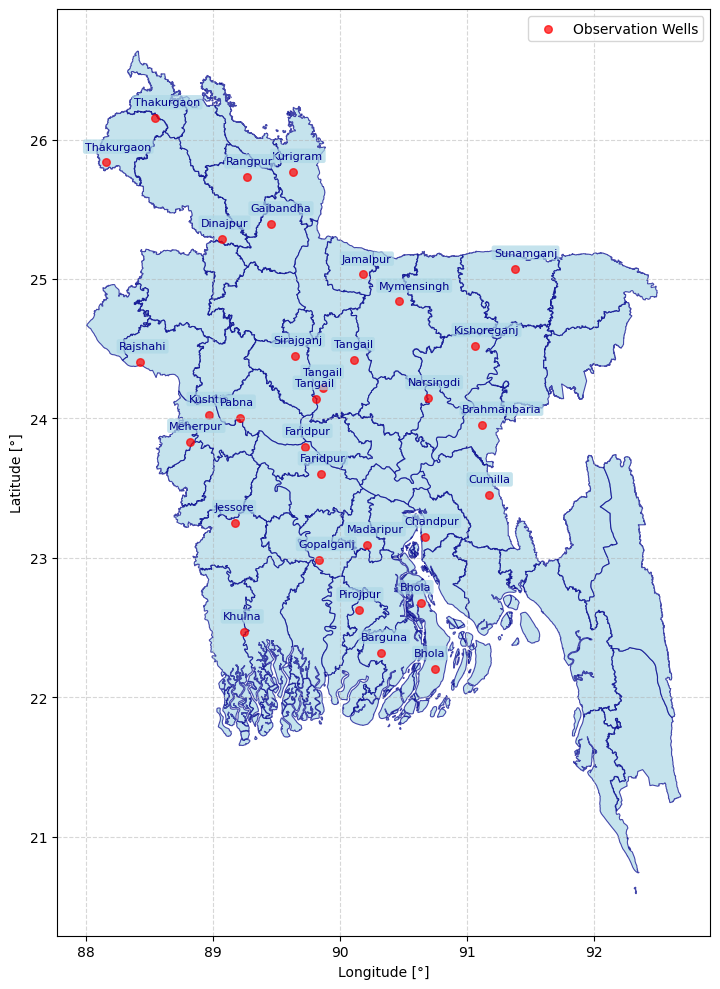

In [53]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the shapefile (e.g., a country or region boundary)
shapefile.plot(ax=ax, color='lightblue', edgecolor='darkblue', linewidth=0.8, alpha=0.7)

# Plot the point GeoDataFrame
gdf.plot(ax=ax, marker='o', color='red', markersize=30, alpha=0.7, label='Observation Wells')
for idx, row in gdf.iterrows():
    ax.annotate(
        text=str(row['District']),
        xy=(row['lon'], row['lat']),
        xytext=(-15, 15),  # offset below the station ID
        textcoords='offset points',
        fontsize=8,
        fontweight='normal',
        color='darkblue',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7, edgecolor='none'),
        ha='left',
        va='top'
    )
# Add optional decorations
# ax.set_title('Spatial Distribution of Observation Wells', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude [°]')
ax.set_ylabel('Latitude [°]')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Optional: remove axes if not needed
# ax.axis('off')

plt.tight_layout()
plt.show()

In [54]:
stats

,District,Upaliza,Well Id,lat,lon,range,mse_lr,mse_xgb,r2_lr,r2_xgb,obs_mean,obs_std,obs_min,obs_max,mbc_mean_lr,mbc_std_lr,mbc_mean_xgb,mbc_std_xgb
0,Barguna,Bamna,GT0419003,22.320000,90.327500,1980 - 2014,0.066981,0.066157,0.549077,0.554623,1.790070,0.385870,1.160000,2.697500,1.790070,0.385870,1.790070,0.383849
1,Bhola,Bhola Sadar,GT0918001,22.675000,90.636100,1980 - 2014,0.262555,0.275373,0.397007,0.367567,1.971684,0.660650,0.910000,4.117500,1.971684,0.660650,1.971684,0.660650
2,Bhola,Char Fasson,GT0925002,22.202800,90.749400,1980 - 2014,0.204461,0.268248,0.444784,0.271567,2.105349,0.607563,0.875000,3.932000,2.105349,0.607563,2.105349,0.607563
3,Brahmanbaria,Brahamanbaria Sadar,GT1213005,23.955600,91.120800,1981 - 2014,0.471676,0.513355,0.727080,0.702964,3.180511,1.316254,0.845000,6.380000,3.180511,1.316254,3.180511,1.316253
4,Chandpur,Chandpur Sadar,GT1322004,23.150000,90.670000,1980 - 2014,0.366172,0.338603,0.432127,0.474883,2.398401,0.803961,0.100000,4.575000,2.398401,0.803961,2.398401,0.803961
5,Cumilla,Cumilla Sadar,GT1967900,23.448660,91.176890,1996 - 2014,3.864675,3.453143,0.385516,0.450950,4.608208,2.513367,0.634333,12.412333,4.608208,2.513366,4.608208,2.513366
6,Dinajpur,Hakimpur,GT2747021,25.290000,89.070000,1980 - 2014,1.699258,1.722657,0.394743,0.386408,3.673723,1.677557,0.398000,7.267500,3.673723,1.677557,3.673723,1.677557
7,Faridpur,Faridpur Sadar,GT2947007,23.600000,89.850000,1980 - 2014,0.516385,0.472036,0.760875,0.781412,3.811849,1.471269,0.637500,6.587500,3.811849,1.471269,3.811849,1.455772
8,Faridpur,Faridpur Sadar,GT2947900,23.797200,89.728300,1996 - 2014,0.171371,0.143201,0.893092,0.910666,4.401105,1.268886,1.066667,6.272333,4.401105,1.268886,4.401105,1.257974
9,Gaibandha,Sadullapur,GT3282011,25.392400,89.462100,1980 - 2014,1.047432,0.844525,0.409931,0.524238,3.530025,1.333918,0.906000,6.535000,3.530025,1.333918,3.530025,1.315322


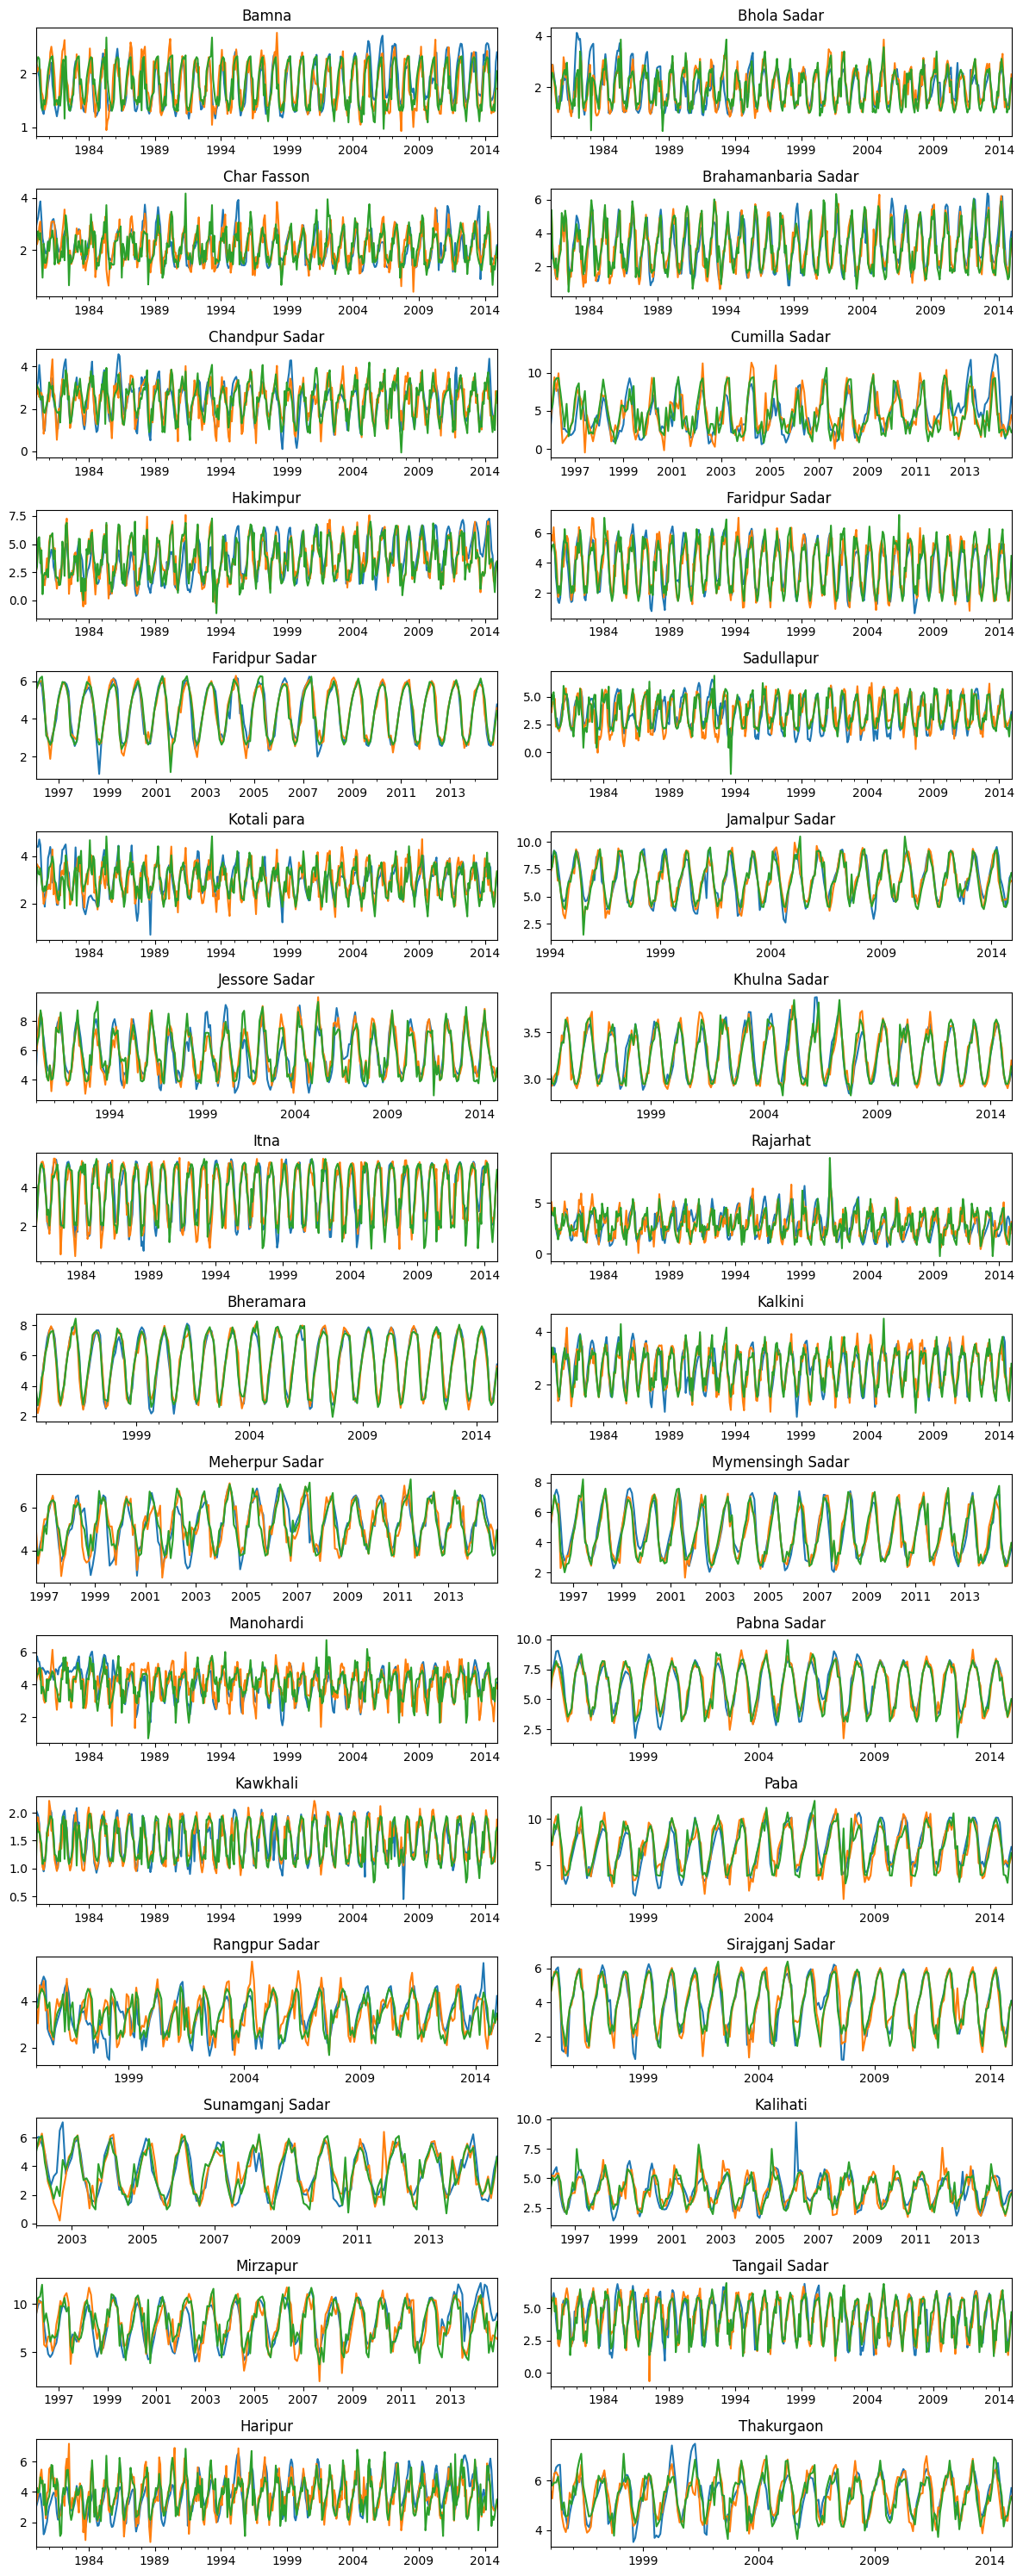

In [56]:
fig, ax = plt.subplots(figsize=(12, 30), ncols= 2, nrows=len(stations_df)//2)
ax = ax.flatten()
for i,df in enumerate(stations_df):
    df[['wtable', 'mbc_hist_lr', 'mbc_hist_xgb']].dropna().plot(ax=ax[i], title=df['UPAZILA'].iloc[0], legend=False)
plt.tight_layout()